# Identifying and Removing Pathological Bounding Boxes

This notebook focuses on identifying and removing problematic bounding boxes from a dataset of images. 
It explores different outlier detection methods (Z-score, IQR, and percentiles) to find bounding boxes with unusually small or large dimensions or area. 
The notebook then proceeds to manually inspect some of the identified small outliers by visualizing their corresponding mask images to determine if the bounding boxes are legitimate or pathological. 
Finally, it removes the images and annotations associated with the identified pathological small bounding boxes from the training dataset.

In [ ]:
import pandas as pd
import os
from pathlib import Path

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set ROOT path
ROOT = Path("/content/drive/MyDrive/ErdosFall25/")

# Pandas dataframe for bounding boxes

First, we pull the appropriate data and create a Pandas dataframe for later analysis.

In [ ]:
# List annotation files
annotation_directory = ROOT / "data/detection2/yolo_split2/train/labels"
annotation_files = [f for f in os.listdir(annotation_directory)
                    if f.lower().endswith(".txt")]
print(f"Found {len(annotation_files)} annotation files.")

Found 4169 annotation files.


In [ ]:
# Process annotation files
bbox_data = []
counter = 0
for file_path in annotation_files:
    image_filename = Path(file_path).stem  # Get image filename from annotation file
    with open(annotation_directory / file_path, 'r') as f:
        lines = f.readlines()
        if not lines:  # Handle files with no bounding boxes
            bbox_data.append({'image_filename': image_filename,
                              'height': None,
                              'width': None})
        else:
            for line in lines:
                # YOLO format: class_id center_x center_y box_width box_height (normalized)
                parts = line.strip().split()
                if len(parts) == 5:
                    # Image dimensions are needed to denormalize,
                    # but for relative height/width/area, we can use the normalized values directly.
                    # For absolute values, we need image dimensions.
                    box_width = float(parts[3])
                    box_height = float(parts[4])
                    bbox_data.append({'image_filename': image_filename,
                                      'height': box_height,
                                      'width': box_width})
                else:
                    print(f"Skipping invalid line: {line}")
    counter += 1
    if counter % 100 == 0:
      print(f"Processed {counter} files.")
      print(f"Current length of bbox_data: {len(bbox_data)}")

Processed 100 files.
Current length of bbox_data: 100
Processed 200 files.
Current length of bbox_data: 201
Processed 300 files.
Current length of bbox_data: 301
Processed 400 files.
Current length of bbox_data: 401
Processed 500 files.
Current length of bbox_data: 502
Processed 600 files.
Current length of bbox_data: 605
Processed 700 files.
Current length of bbox_data: 705
Processed 800 files.
Current length of bbox_data: 805
Processed 900 files.
Current length of bbox_data: 905
Processed 1000 files.
Current length of bbox_data: 1005
Processed 1100 files.
Current length of bbox_data: 1105
Processed 1200 files.
Current length of bbox_data: 1205
Processed 1300 files.
Current length of bbox_data: 1305
Processed 1400 files.
Current length of bbox_data: 1405
Processed 1500 files.
Current length of bbox_data: 1505
Processed 1600 files.
Current length of bbox_data: 1605
Processed 1700 files.
Current length of bbox_data: 1707
Processed 1800 files.
Current length of bbox_data: 1807
Processed 

In [ ]:
# Create DataFrame
bbox_df = pd.DataFrame(bbox_data)
display(bbox_df.head())

,image_filename,height,width
0,seq5_neg__EndoCV2021_seq5_neg_Image_51998,NaN,NaN
1,seq5__EndoCV2021_seq5_988,0.578008,0.411111
2,seq5__EndoCV2021_seq5_944,0.127820,0.311111
3,seq5__EndoCV2021_seq5_996,0.766917,0.400000
4,seq5_neg__EndoCV2021_seq5_neg_Image_54078,NaN,NaN


In [ ]:
# Area column
bbox_df['area'] = bbox_df['height'] * bbox_df['width']
display(bbox_df.head())

,image_filename,height,width,area
0,seq5_neg__EndoCV2021_seq5_neg_Image_51998,NaN,NaN,NaN
1,seq5__EndoCV2021_seq5_988,0.578008,0.411111,0.237625
2,seq5__EndoCV2021_seq5_944,0.127820,0.311111,0.039766
3,seq5__EndoCV2021_seq5_996,0.766917,0.400000,0.306767
4,seq5_neg__EndoCV2021_seq5_neg_Image_54078,NaN,NaN,NaN


In [ ]:
# Summary statistics
bbox_df.describe()

,height,width,area
count,2232.000000,2232.000000,2232.000000
mean,0.352779,0.251796,0.118015
std,0.241369,0.159037,0.144603
min,0.000926,0.000781,0.000054
25%,0.162963,0.137500,0.022055
50%,0.288889,0.216667,0.062157
75%,0.466165,0.333333,0.151192
max,0.999074,0.995556,0.938006


# Finding outliers

We want to systematically identify outliers because we've previously seen
(via manual inspection of false positives and false negatives during model evaluation)
that some images have nonsensical ground truth bounding boxes
(probably caused by artifacts from pixel masks).

To find outliers, we tried a few methods.
1. Find bounding boxes whose height, width, or area are sufficiently many standard deviations away from the mean.
2. Find bounding boxes whose height, width, or area are outside a specified interquartile range.
3. Find bounding boxes whose height, width, or area are in the highest or lowest percentiles.

The first two methods failed to capture outliers whose heights, width, or area were small, because the mean size of a bounding box is already small.
(These techniques would have worked better if we did a log transformation first.)
The third method successfully allowed us to filter the bounding boxes that were extremely small.

## First attempt: Z-score

First, we tried outlier detection with Z-score.

In [ ]:
from scipy import stats

# Drop rows with NaN values in 'height', 'width', or 'area' before calculating z-scores
bbox_df_cleaned = bbox_df.dropna(subset=['height', 'width', 'area'])

# Calculate the Z-scores for each column on the cleaned data
# z_scores = bbox_df_cleaned[['height', 'width', 'area']].apply(stats.zscore)

# Find rows where the absolute z-score is greater than 3 in any of the columns
# outlier_rows = (z_scores.abs() > 3).any(axis=1)

# Filter the original DataFrame to get only the outlier rows
# outliers_df = bbox_df_cleaned[outlier_rows]

outliers_df = bbox_df_cleaned[(bbox_df_cleaned[['height', 'width', 'area']]
                               .apply(stats.zscore).abs() > 3).any(axis=1)]

display(outliers_df)

,image_filename,height,width,area
223,seq6__2_endocv2021_positive_1413,0.933333,0.679167,0.633889
251,seq6__2_endocv2021_positive_1403,0.896296,0.666667,0.597531
261,seq6__2_endocv2021_positive_1422,0.932407,0.683333,0.637144
2451,seq13__EndoCV2021_seq13_168,0.954887,0.650000,0.620677
2480,seq13__EndoCV2021_seq13_172,0.872180,0.944444,0.823725
2486,seq13__EndoCV2021_seq13_184,0.999060,0.694444,0.693791
2488,seq13__EndoCV2021_seq13_188,0.999060,0.705556,0.704893
2492,seq13__EndoCV2021_seq13_180,0.999060,0.700000,0.699342
2496,seq13__EndoCV2021_seq13_176,0.999060,0.938889,0.938006
2510,seq13__EndoCV2021_seq13_528,0.999060,0.683333,0.682691


In [ ]:
outliers_df.describe()

,height,width,area
count,57.000000,57.000000,57.000000
mean,0.864527,0.751182,0.644920
std,0.170588,0.092845,0.136348
min,0.414815,0.600000,0.338766
25%,0.806481,0.683333,0.579699
50%,0.932407,0.733333,0.643838
75%,0.999060,0.805926,0.710453
max,0.999074,0.995556,0.938006


Z-score isn't detecting the bounding boxes with extremely small heights, widths, or area.

## Second attempt: Interquartile range

Next, we used IQR to detect outliers.

In [ ]:
# Calculate Q1, Q3, and IQR for each column
Q1 = bbox_df_cleaned[['height', 'width', 'area']].quantile(0.25)
Q3 = bbox_df_cleaned[['height', 'width', 'area']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers using the IQR method
# A data point is an outlier if it falls below the lower bound or above the upper bound
iqr_outliers_df = bbox_df_cleaned[((bbox_df_cleaned[['height', 'width', 'area']]
                                    < lower_bound)
                                  | (bbox_df_cleaned[['height', 'width', 'area']]
                                     > upper_bound)).any(axis=1)]

display(iqr_outliers_df)

,image_filename,height,width,area
146,seq6__2_endocv2021_positive_1389,0.651852,0.554167,0.361235
213,seq6__2_endocv2021_positive_1390,0.674074,0.575000,0.387593
223,seq6__2_endocv2021_positive_1413,0.933333,0.679167,0.633889
251,seq6__2_endocv2021_positive_1403,0.896296,0.666667,0.597531
261,seq6__2_endocv2021_positive_1422,0.932407,0.683333,0.637144
...,...,...,...,...
4207,single__150OLCV1_100H0016,0.522222,0.788148,0.411588
4244,single__22_endocv2021_positive_1266,0.711111,0.529167,0.376296
4265,single__199OLCV1_100H0010,0.893130,0.792208,0.707545
4275,single__186OLCV1_100H0053,0.793893,0.655844,0.520670


In [ ]:
iqr_outliers_df.describe()

,height,width,area
count,198.000000,198.000000,198.000000
mean,0.844713,0.576756,0.480763
std,0.138880,0.153128,0.142274
min,0.414815,0.204167,0.192322
25%,0.741646,0.500000,0.377562
50%,0.888426,0.561111,0.451756
75%,0.960498,0.683333,0.543526
max,0.999074,0.995556,0.938006


Evidently, this method also fails to capture the small outliers....
The problem is that `lower_bound` becomes negative.

In [ ]:
lower_bound

,0
height,-0.291840
width,-0.156249
area,-0.171650


## Third attempt: Percentiles
Let's just look at everything below the 5th percentile
and above the 95th percentile.

In [ ]:
# Calculate the 5th and 95th percentiles for each column
lower_percentile = bbox_df_cleaned[['height', 'width', 'area']].quantile(0.05)
upper_percentile = bbox_df_cleaned[['height', 'width', 'area']].quantile(0.95)

# Find outliers using percentiles
# A data point is an outlier if it falls below the lower percentile or above the upper percentile
percentile_outliers_df = bbox_df_cleaned[((bbox_df_cleaned[['height', 'width', 'area']]
                                           < lower_percentile)
                                          | (bbox_df_cleaned[['height', 'width', 'area']]
                                             > upper_percentile)).any(axis=1)]

display(percentile_outliers_df)

,image_filename,height,width,area
12,seq5__EndoCV2021_seq5_896,0.045113,0.138889,0.006266
21,seq5__EndoCV2021_seq5_892,0.067669,0.144444,0.009774
67,seq5__EndoCV2021_seq5_900,0.067669,0.205556,0.013910
94,seq6__2_endocv2021_positive_1195,0.437037,0.579167,0.253117
151,seq6__2_endocv2021_positive_1198,0.444444,0.575000,0.255555
...,...,...,...,...
4299,single__22_endocv2021_positive_625,0.081481,0.050000,0.004074
4300,single__18_endocv2021_positive_960,0.088889,0.050000,0.004444
4303,single__234OLCV1_100H0020,0.068702,0.149351,0.010261
4308,single__18_endocv2021_positive_1492,0.111111,0.045833,0.005093


In [ ]:
percentile_outliers_df.describe()

,height,width,area
count,341.000000,341.000000,341.000000
mean,0.492217,0.342132,0.259142
std,0.400800,0.283957,0.262205
min,0.000926,0.000781,0.000054
25%,0.069444,0.062500,0.004722
50%,0.562249,0.279167,0.253750
75%,0.909774,0.594444,0.475104
max,0.999074,0.995556,0.938006


It might be worth separating the small outliers from the large outliers.

In [ ]:
small_outliers_df = bbox_df_cleaned[((bbox_df_cleaned[['height', 'width', 'area']]
                                     < lower_percentile)).any(axis=1)]
display(small_outliers_df)

,image_filename,height,width,area
12,seq5__EndoCV2021_seq5_896,0.045113,0.138889,0.006266
21,seq5__EndoCV2021_seq5_892,0.067669,0.144444,0.009774
67,seq5__EndoCV2021_seq5_900,0.067669,0.205556,0.013910
155,seq6__2_endocv2021_positive_1197,0.164815,0.001042,0.000172
464,seq8__3_endocv2021_positive_731,0.134259,0.001563,0.000210
...,...,...,...,...
4295,single__226OLCV1_100H0002,0.054630,0.041481,0.002266
4299,single__22_endocv2021_positive_625,0.081481,0.050000,0.004074
4300,single__18_endocv2021_positive_960,0.088889,0.050000,0.004444
4303,single__234OLCV1_100H0020,0.068702,0.149351,0.010261


In [ ]:
small_outliers_df.describe()

,height,width,area
count,156.000000,156.000000,156.000000
mean,0.077750,0.067552,0.004476
std,0.047724,0.039113,0.003029
min,0.000926,0.000781,0.000054
25%,0.052632,0.049089,0.002593
50%,0.069444,0.061458,0.004288
75%,0.091039,0.078943,0.006157
max,0.285185,0.238021,0.015278


In [ ]:
large_outliers_df = bbox_df_cleaned[((bbox_df_cleaned[['height', 'width', 'area']]
                                     > upper_percentile)).any(axis=1)]

display(large_outliers_df)

,image_filename,height,width,area
94,seq6__2_endocv2021_positive_1195,0.437037,0.579167,0.253117
151,seq6__2_endocv2021_positive_1198,0.444444,0.575000,0.255555
154,seq6__2_endocv2021_positive_1197,0.437037,0.570833,0.249475
213,seq6__2_endocv2021_positive_1390,0.674074,0.575000,0.387593
223,seq6__2_endocv2021_positive_1413,0.933333,0.679167,0.633889
...,...,...,...,...
4183,single__176OLCV1_100H0889,0.580153,0.571429,0.331516
4207,single__150OLCV1_100H0016,0.522222,0.788148,0.411588
4265,single__199OLCV1_100H0010,0.893130,0.792208,0.707545
4275,single__186OLCV1_100H0053,0.793893,0.655844,0.520670


In [ ]:
large_outliers_df.describe()

,height,width,area
count,185.000000,185.000000,185.000000
mean,0.841714,0.573670,0.473888
std,0.162675,0.172864,0.160254
min,0.348148,0.182222,0.163325
25%,0.748148,0.505556,0.358001
50%,0.902256,0.583333,0.463210
75%,0.966667,0.688889,0.547073
max,0.999074,0.995556,0.938006


# Manually examining outliers with small bounding boxes

We wanted to examine both the bounding boxes and pixel masks of the outliers to see if they made sense.
Below, we visualize pixel masks to identify possibly pathological examples, then compare with the bounding boxes to confirm.

In [ ]:
print(small_outliers_df['image_filename'].to_string(index=False))

            seq5__EndoCV2021_seq5_896
            seq5__EndoCV2021_seq5_892
            seq5__EndoCV2021_seq5_900
     seq6__2_endocv2021_positive_1197
      seq8__3_endocv2021_positive_731
      seq8__3_endocv2021_positive_861
     seq8__3_endocv2021_positive_1041
      seq8__3_endocv2021_positive_878
      seq9__7_endocv2021_positive_261
      seq9__7_endocv2021_positive_260
      seq3__1_endocv2021_positive_343
      seq4__1_endocv2021_positive_409
            seq5__EndoCV2021_seq5_880
            seq5__EndoCV2021_seq5_884
            seq5__EndoCV2021_seq5_680
            seq5__EndoCV2021_seq5_888
seq11__EndoCV2021_seq11_Image_2199921
seq11__EndoCV2021_seq11_Image_2199601
seq11__EndoCV2021_seq11_Image_2198761
seq11__EndoCV2021_seq11_Image_2198801
seq11__EndoCV2021_seq11_Image_2199801
seq11__EndoCV2021_seq11_Image_2199481
seq11__EndoCV2021_seq11_Image_2198921
seq11__EndoCV2021_seq11_Image_2199121
seq11__EndoCV2021_seq11_Image_2198881
seq11__EndoCV2021_seq11_Image_2198081
seq11__EndoC

In [ ]:
def get_mask_filename(image_filename):
  """
  Finds the mask filename for a given image filename.

  Args:
    image_filename: The filename of the image (without extension).

  Returns:
    The filename of the corresponding mask, or None if not found.
  """
  # Deal with sequences
  # There are 23 positive sequences
  # The mask filename is not standardized across the folders,
  # but as long we strip "seq{num}__" from the front
  # and add "_mask.jpg" to the end,
  # we should at least have the correct filename.
  for seq_num in range(1,24):
    if image_filename.startswith(f"seq{seq_num}__"):
      # Filename with no extension
      mask_filename = image_filename.removeprefix(f"seq{seq_num}__") + "_mask"
      return mask_filename

  # Deal with singles
  # Again, the filename is not standardized across folders.
  # It will be annoying to systematically find the correct folder,
  # but as long as we strip "single__" from the front
  # and add "_mask.jpg" to the end,
  # we should at least have the correct filename.
  if image_filename.startswith("single__"):
    # Filename with no extension
    mask_filename = image_filename.removeprefix("single__") + "_mask"
    return mask_filename

  else:
    raise ValueError(f"Could not find mask for image {image_filename}.")

In [ ]:
import glob

def get_mask_path(mask_filename):
  """
  Finds the full path to a mask file using glob, searching within the ROOT directory.

  Args:
    mask_filename: The filename of the mask (without extension).

  Returns:
    The full path to the mask file, or None if not found.
  """
  # Use glob to search for the mask file with a .jpg extension within the ROOT directory
  # The ** allows searching in subdirectories
  # We should look only in the PolypGenV3 folder
  mask_path = glob.glob(str(ROOT / "data/PolypGenV3" / "**" / f"{mask_filename}.jpg"), recursive=True)

  if mask_path:
    # glob returns a list, so take the first match
    return Path(mask_path[0])
  else:
    print(f"Mask file {mask_filename} not found.")
    return None

In [ ]:
small_outliers_df['mask_filename'] = small_outliers_df['image_filename'].apply(get_mask_filename)
display(small_outliers_df)

/tmp/ipython-input-2435331444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_outliers_df['mask_filename'] = small_outliers_df['image_filename'].apply(get_mask_filename)


,image_filename,height,width,area,mask_filename
12,seq5__EndoCV2021_seq5_896,0.045113,0.138889,0.006266,EndoCV2021_seq5_896_mask
21,seq5__EndoCV2021_seq5_892,0.067669,0.144444,0.009774,EndoCV2021_seq5_892_mask
67,seq5__EndoCV2021_seq5_900,0.067669,0.205556,0.013910,EndoCV2021_seq5_900_mask
155,seq6__2_endocv2021_positive_1197,0.164815,0.001042,0.000172,2_endocv2021_positive_1197_mask
464,seq8__3_endocv2021_positive_731,0.134259,0.001563,0.000210,3_endocv2021_positive_731_mask
...,...,...,...,...,...
4295,single__226OLCV1_100H0002,0.054630,0.041481,0.002266,226OLCV1_100H0002_mask
4299,single__22_endocv2021_positive_625,0.081481,0.050000,0.004074,22_endocv2021_positive_625_mask
4300,single__18_endocv2021_positive_960,0.088889,0.050000,0.004444,18_endocv2021_positive_960_mask
4303,single__234OLCV1_100H0020,0.068702,0.149351,0.010261,234OLCV1_100H0020_mask


In [ ]:
small_outliers_df['mask_path'] = small_outliers_df['mask_filename'].apply(get_mask_path)
display(small_outliers_df)

/tmp/ipython-input-2505486995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_outliers_df['mask_path'] = small_outliers_df['mask_filename'].apply(get_mask_path)


,image_filename,height,width,area,mask_filename,mask_path
12,seq5__EndoCV2021_seq5_896,0.045113,0.138889,0.006266,EndoCV2021_seq5_896_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
21,seq5__EndoCV2021_seq5_892,0.067669,0.144444,0.009774,EndoCV2021_seq5_892_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
67,seq5__EndoCV2021_seq5_900,0.067669,0.205556,0.013910,EndoCV2021_seq5_900_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
155,seq6__2_endocv2021_positive_1197,0.164815,0.001042,0.000172,2_endocv2021_positive_1197_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
464,seq8__3_endocv2021_positive_731,0.134259,0.001563,0.000210,3_endocv2021_positive_731_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
...,...,...,...,...,...,...
4295,single__226OLCV1_100H0002,0.054630,0.041481,0.002266,226OLCV1_100H0002_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
4299,single__22_endocv2021_positive_625,0.081481,0.050000,0.004074,22_endocv2021_positive_625_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
4300,single__18_endocv2021_positive_960,0.088889,0.050000,0.004444,18_endocv2021_positive_960_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
4303,single__234OLCV1_100H0020,0.068702,0.149351,0.010261,234OLCV1_100H0020_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image_from_path(image_path):
  """
  Displays an image from the given file path.

  Args:
    image_path: The full path to the image file.
  """
  try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.show()
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

Displaying mask for image: single__C3_EndoCV2021_00380


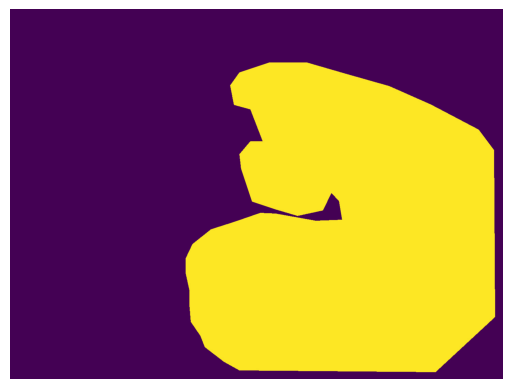

Displaying mask for image: single__6_endocv2021_positive_233


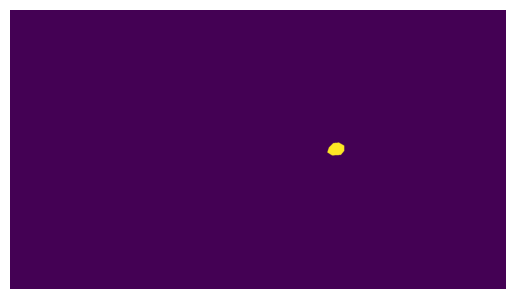

Displaying mask for image: single__C3_EndoCV2021_00261


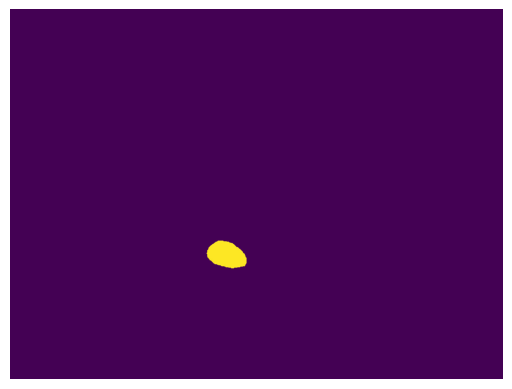

Displaying mask for image: single__9_endocv2021_positive_538


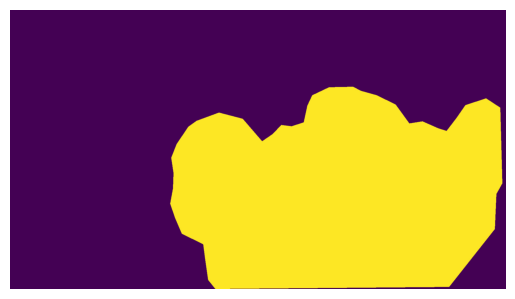

Displaying mask for image: single__EndoCV2021_C5_50000066


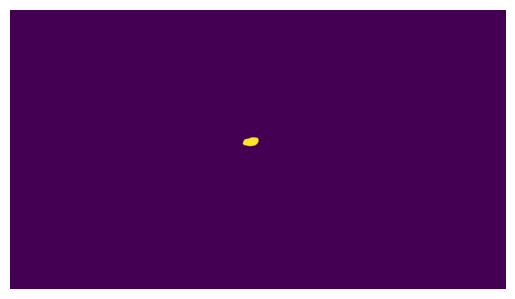

Displaying mask for image: seq11__EndoCV2021_seq11_Image_2198401


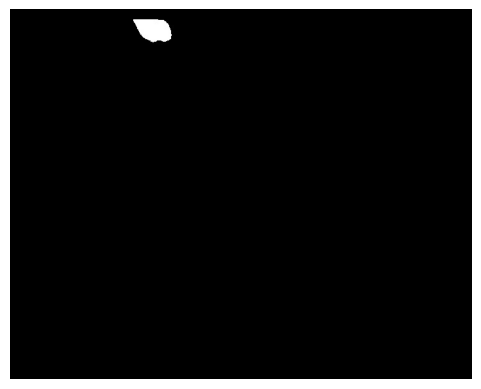

Displaying mask for image: single__C3_EndoCV2021_00367


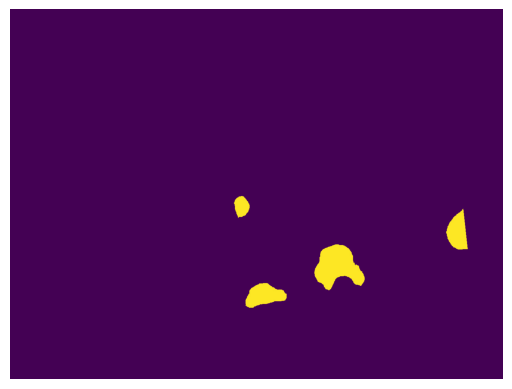

Displaying mask for image: single__EndoCV2021_C5_50000264


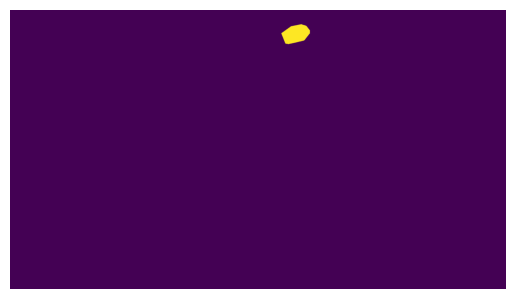

Displaying mask for image: single__C3_EndoCV2021_00367


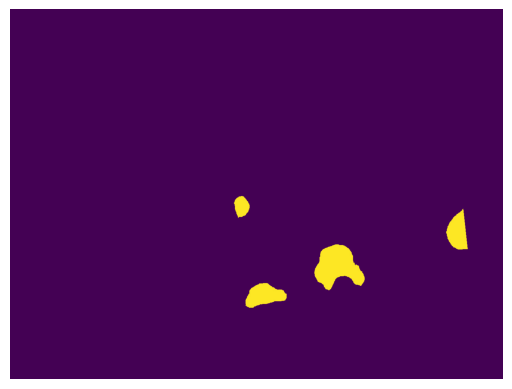

Displaying mask for image: single__10_endocv2021_positive_895


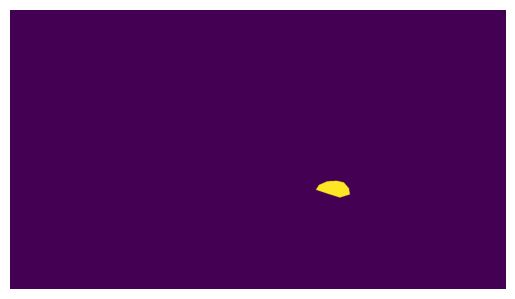

In [ ]:
# Select a few random rows from the small_outliers_df
num_images_to_display = 10  # You can change this number
random_outliers = small_outliers_df.sample(n=min(num_images_to_display,
                                                 len(small_outliers_df)),
                                           random_state=42) # For reproducibility

# Display the mask image for each selected outlier
for index, row in random_outliers.iterrows():
    mask_path = row['mask_path']
    image_filename = row['image_filename']
    if mask_path and Path(mask_path).exists():
        print(f"Displaying mask for image: {image_filename}")
        display_image_from_path(mask_path)
    else:
        print(f"Mask file not found for image: {image_filename}")

What we would expect to see in these pixel masks are very small regions classified as polyps.
For some of these masks, that is exactly what we see, and we should not treat the corresponding images as pathological.

However, some of the pixel masks show very *large* regions classified as polyps.
For example, in the masks for the images
`single__C3_EndoCV2021_00380`
and
`single__9_endocv2021_positive_538`,
we see very large polyp regions,
and we *do not* see anything that looks like it should have a small bounding box.

Let's look at the corresponding images.


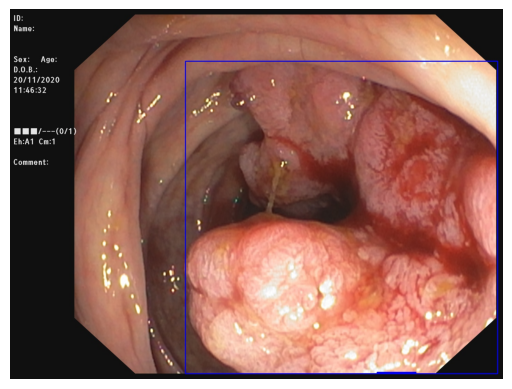

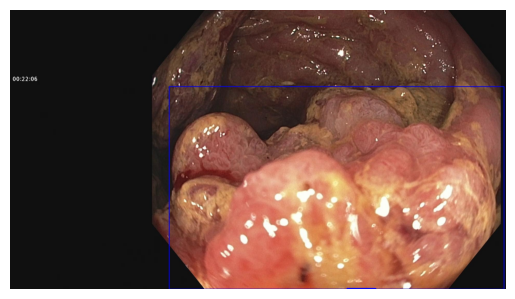

In [ ]:
display_image_from_path("/content/drive/MyDrive/ErdosFall25/data/PolypGenV3/data_C3/bbox_image_C3/C3_EndoCV2021_00380_bbox.jpg")
display_image_from_path("/content/drive/MyDrive/ErdosFall25/data/PolypGenV3/data_C4/bbox_image_C4/9_endocv2021_positive_538_mask_bbox.jpg")

If you look *very closely*, at the bottom of these images, we find bounding boxes that are extremely small.
In these two cases, the bounding boxes have a height of nearly zero.
One might guess that these erroneous bounding boxes arise from artifacts related to the original pixel masks.

In any case, we would like to eliminate any such pathological examples from the training data.

# Finding all the pathological small bounding boxes

Below, we try to find *all* of these pathological examples.
One approach would be to simply filter through all bounding boxes whose area is nearly zero.
By manual inspection, we can identify which examples are pathological and which are legitimate.

In [ ]:
# Sort small outliers by area
small_outliers_sorted_by_area = small_outliers_df.sort_values(by='area')
display(small_outliers_sorted_by_area)

,image_filename,height,width,area,mask_filename,mask_path
3243,single__9_endocv2021_positive_538,0.000926,0.058333,0.000054,9_endocv2021_positive_538_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
3623,single__EndoCV2021_001118,0.111328,0.000781,0.000087,EndoCV2021_001118_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
3095,single__398OLCV1_100H0004,0.115458,0.000812,0.000094,398OLCV1_100H0004_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
4191,single__14_endocv2021_positive_902,0.001852,0.067188,0.000124,14_endocv2021_positive_902_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
3046,single__295OLCV1_100H0004,0.000954,0.142857,0.000136,295OLCV1_100H0004_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
...,...,...,...,...,...,...
1618,seq4__1_endocv2021_positive_409,0.073148,0.162500,0.011887,1_endocv2021_positive_409_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
1933,seq5__EndoCV2021_seq5_880,0.075188,0.177778,0.013367,EndoCV2021_seq5_880_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
67,seq5__EndoCV2021_seq5_900,0.067669,0.205556,0.013910,EndoCV2021_seq5_900_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...
1995,seq5__EndoCV2021_seq5_888,0.075188,0.188889,0.014202,EndoCV2021_seq5_888_mask,/content/drive/MyDrive/ErdosFall25/data/PolypG...


Displaying mask for image: single__9_endocv2021_positive_538


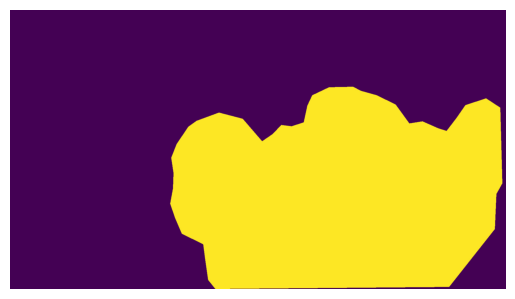

Displaying mask for image: single__EndoCV2021_001118


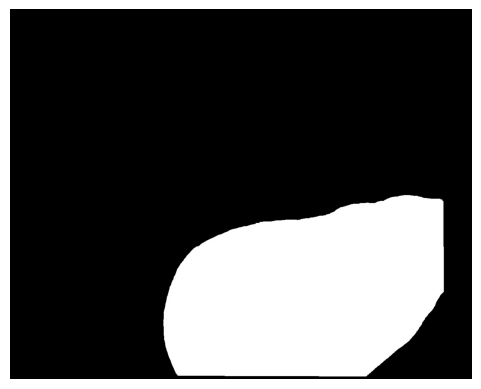

Displaying mask for image: single__398OLCV1_100H0004


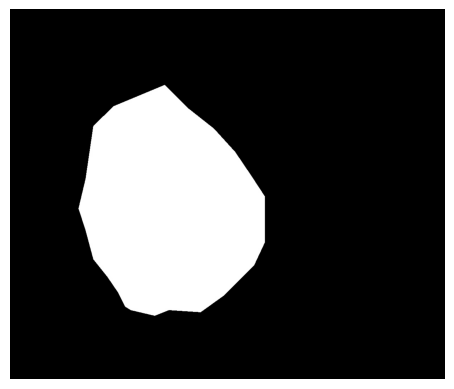

Displaying mask for image: single__14_endocv2021_positive_902


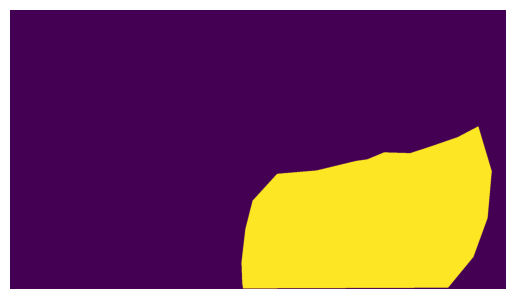

Displaying mask for image: single__295OLCV1_100H0004


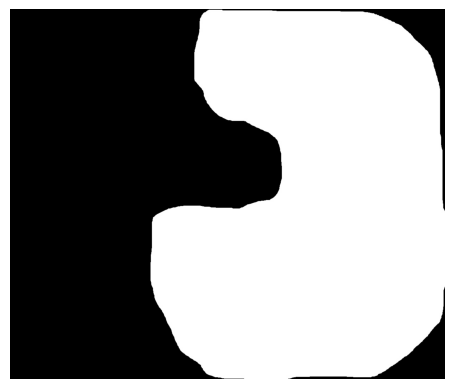

Displaying mask for image: single__C3_EndoCV2021_00380


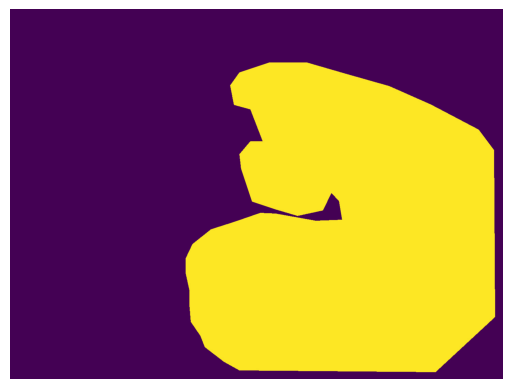

Displaying mask for image: single__9_endocv2021_positive_1269


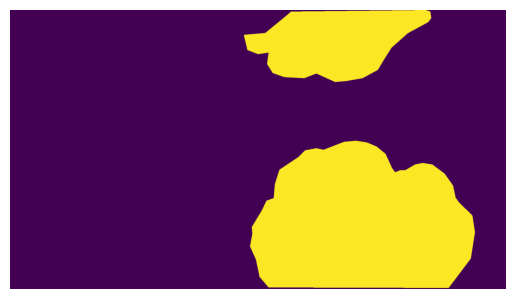

Displaying mask for image: seq5__EndoCV2021_seq5_680


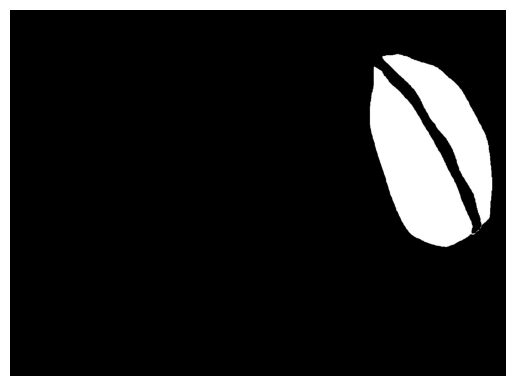

Displaying mask for image: single__EndoCV2021_C5_50000346


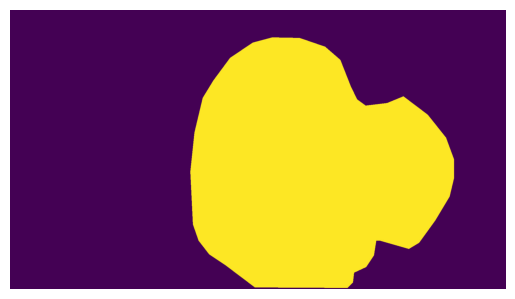

Displaying mask for image: seq6__2_endocv2021_positive_1197


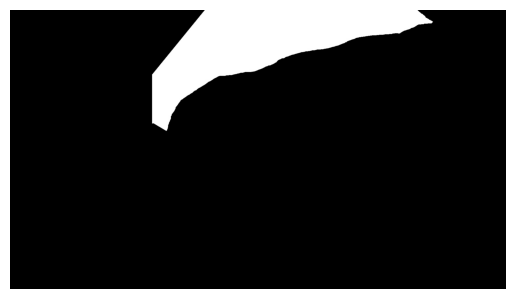

In [ ]:
# Display the mask image for each of the top 10 smallest outliers
for index, row in small_outliers_sorted_by_area.head(10).iterrows():
    mask_path = row['mask_path']
    image_filename = row['image_filename']
    if mask_path and Path(mask_path).exists():
        print(f"Displaying mask for image: {image_filename}")
        display_image_from_path(mask_path)
    else:
        print(f"Mask file not found for image: {image_filename}")

Visually, none of these look like they should have a tiny bounding box, so they are all pathological examples.
Let's look at more examples.

Displaying mask for image: single__9_endocv2021_positive_586


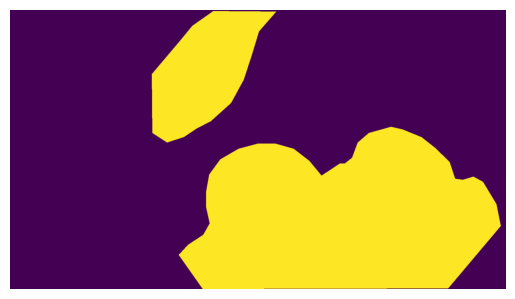

Displaying mask for image: seq8__3_endocv2021_positive_878


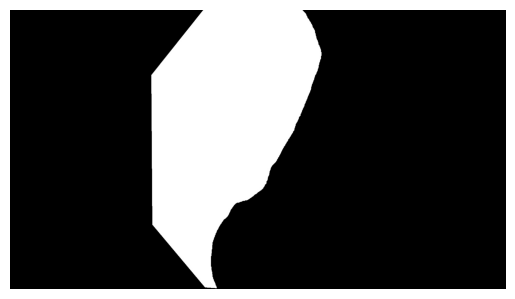

Displaying mask for image: single__EndoCV2021_001112


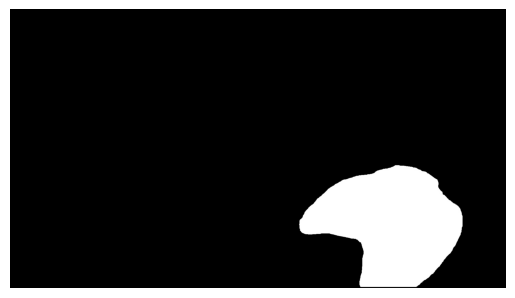

Displaying mask for image: seq8__3_endocv2021_positive_731


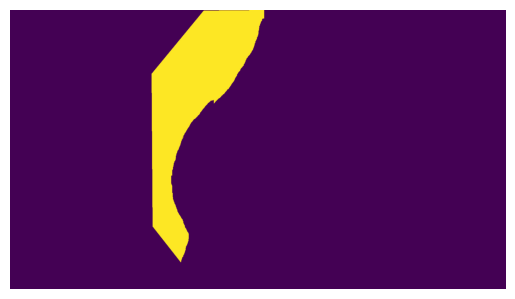

Displaying mask for image: single__459OLCV1_100H0012


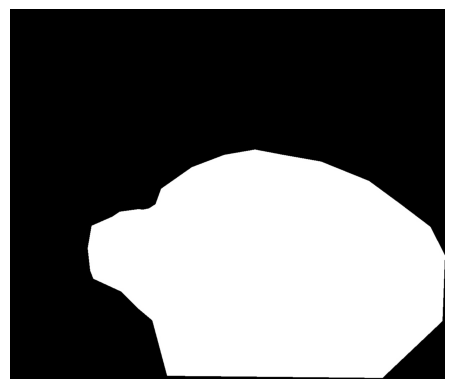

Displaying mask for image: single__EndoCV2021_001124


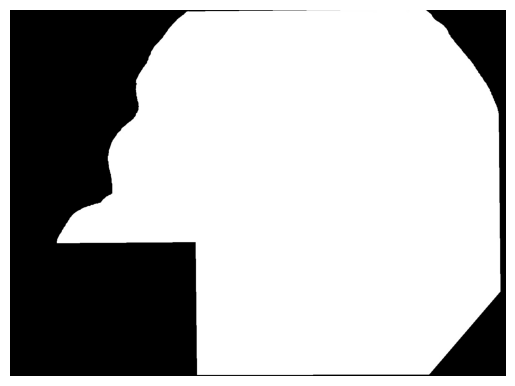

Displaying mask for image: seq8__3_endocv2021_positive_861


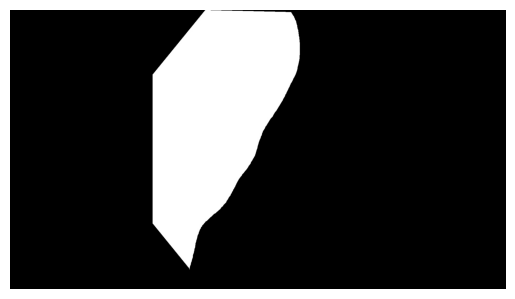

Displaying mask for image: seq3__1_endocv2021_positive_343


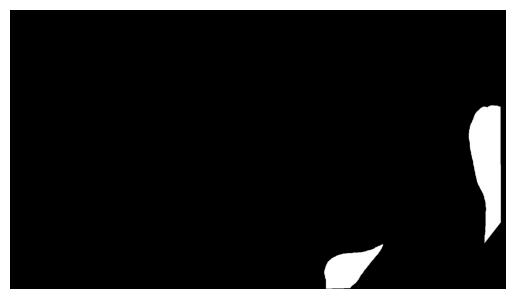

Displaying mask for image: seq8__3_endocv2021_positive_1041


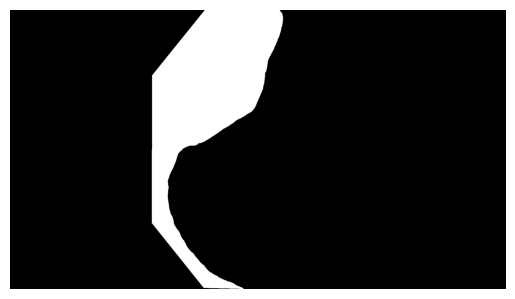

Displaying mask for image: single__14_endocv2021_positive_1266


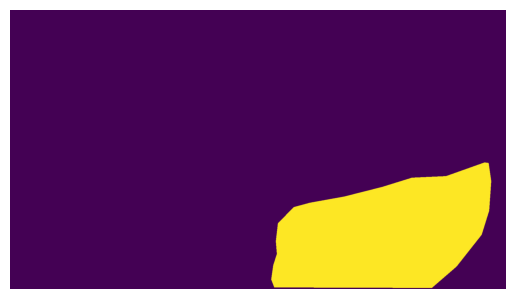

In [ ]:
# Display the mask image for each of these outliers
for index, row in small_outliers_sorted_by_area.iloc[10:20].iterrows():
    mask_path = row['mask_path']
    image_filename = row['image_filename']
    if mask_path and Path(mask_path).exists():
        print(f"Displaying mask for image: {image_filename}")
        display_image_from_path(mask_path)
    else:
        print(f"Mask file not found for image: {image_filename}")

Again, all of these are pathological.
Let's keep going.

Displaying mask for image: single__C3_EndoCV2021_00145


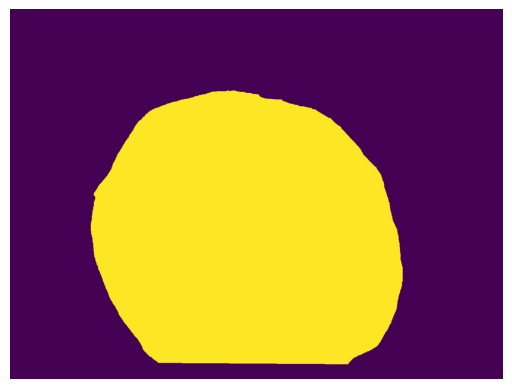

Displaying mask for image: single__C3_EndoCV2021_00474


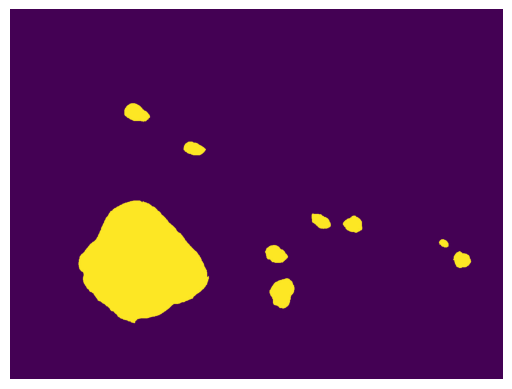

Displaying mask for image: single__C3_EndoCV2021_00341


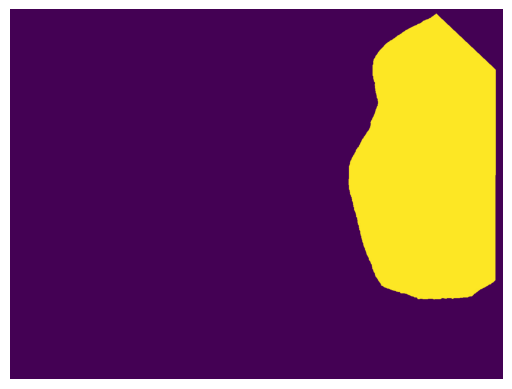

Displaying mask for image: single__C3_EndoCV2021_00449


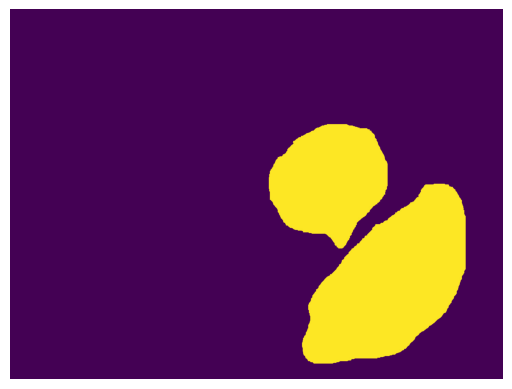

Displaying mask for image: single__C3_EndoCV2021_00341


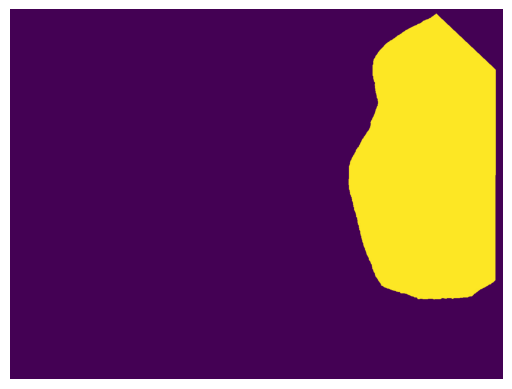

Displaying mask for image: single__EndoCV2021_C5_50000066


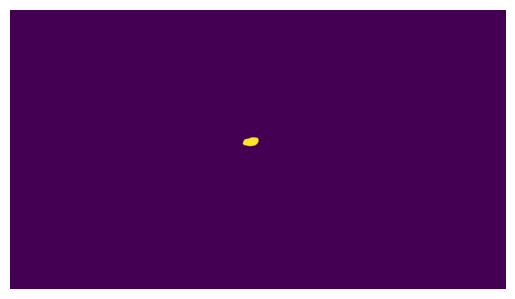

Displaying mask for image: seq12__EndoCV2021_seq12_592


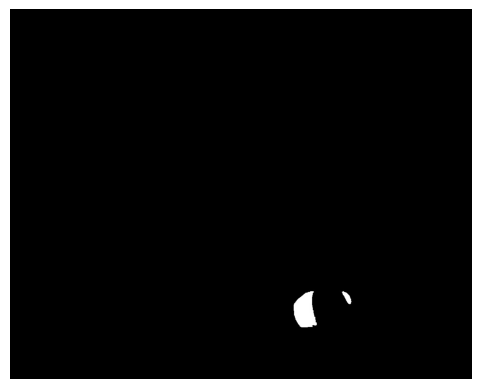

Displaying mask for image: single__169OLCV1_100H0007


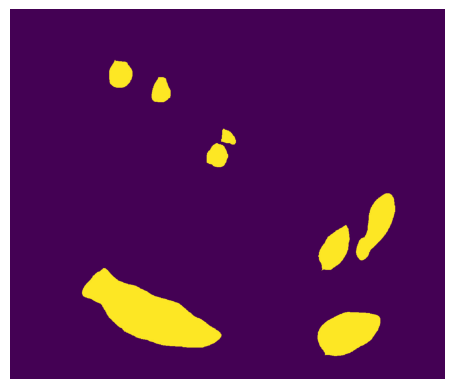

Displaying mask for image: single__EndoCV2021_C5_50000221


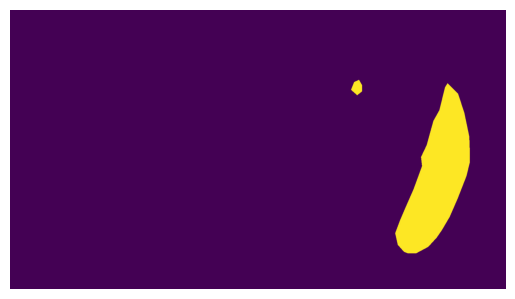

Displaying mask for image: single__EndoCV2021_C5_50000222


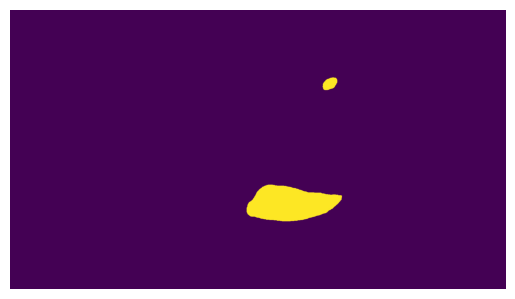

In [ ]:
# Display the mask image for each of these outliers
for index, row in small_outliers_sorted_by_area.iloc[20:30].iterrows():
    mask_path = row['mask_path']
    image_filename = row['image_filename']
    if mask_path and Path(mask_path).exists():
        print(f"Displaying mask for image: {image_filename}")
        display_image_from_path(mask_path)
    else:
        print(f"Mask file not found for image: {image_filename}")

A few of these images are pathological
(i.e. the masks where only large regions are visible),
but we have gotten to the point where many of our masks have legitimately small regions.
For example, `single__C3_EndoCV2021_00474` visibly has 9 regions.
When I checked the corresponding bbox annotation, I found 9 regions, as expected,
so `single__C3_EndoCV2021_00474` is legitimate.

Let's look at 10 more images for good measure.

Displaying mask for image: single__6_endocv2021_positive_233


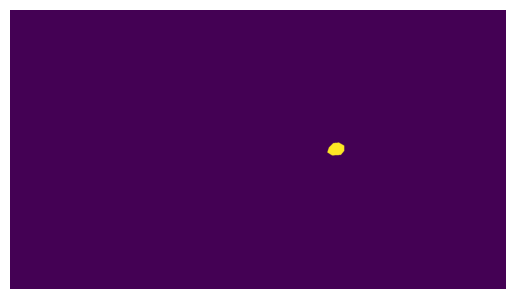

Displaying mask for image: single__C3_EndoCV2021_00474


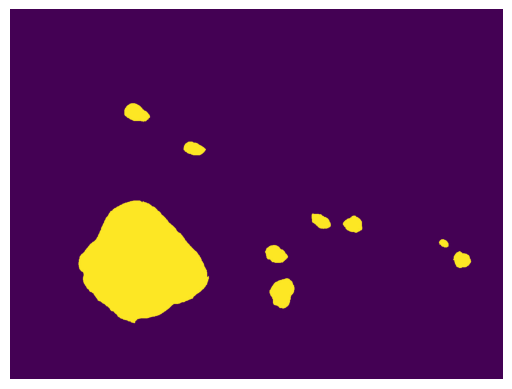

Displaying mask for image: single__226OLCV1_100H0002


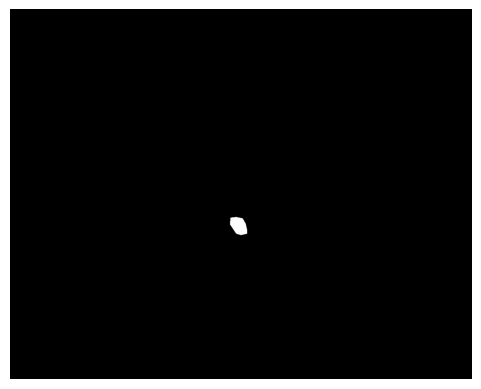

Displaying mask for image: single__C3_EndoCV2021_00474


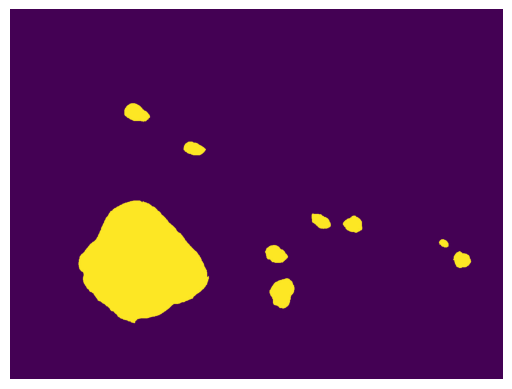

Displaying mask for image: single__C3_EndoCV2021_00474


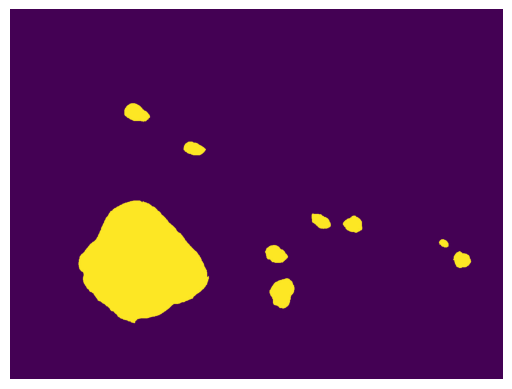

Displaying mask for image: single__C3_EndoCV2021_00474


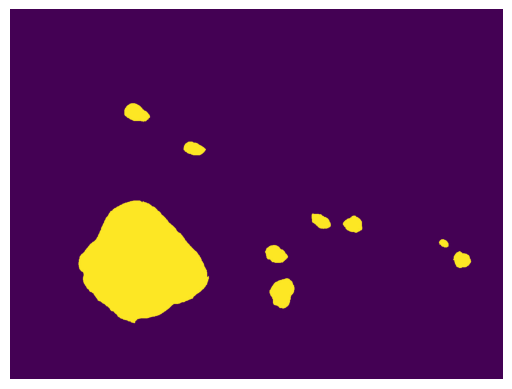

Displaying mask for image: seq11__EndoCV2021_seq11_Image_2199921


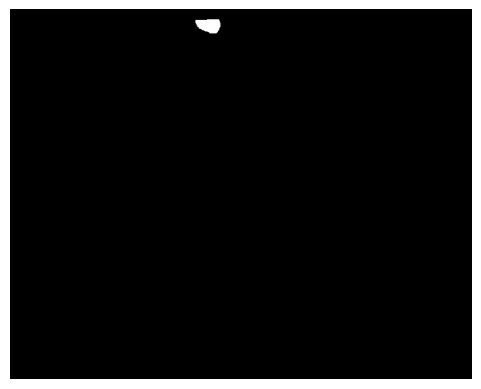

Displaying mask for image: seq13__EndoCV2021_seq13_360


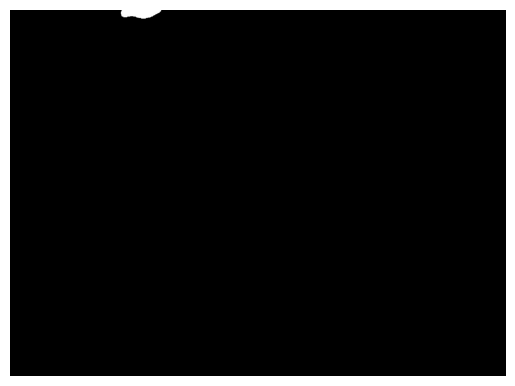

Displaying mask for image: single__C3_EndoCV2021_00474


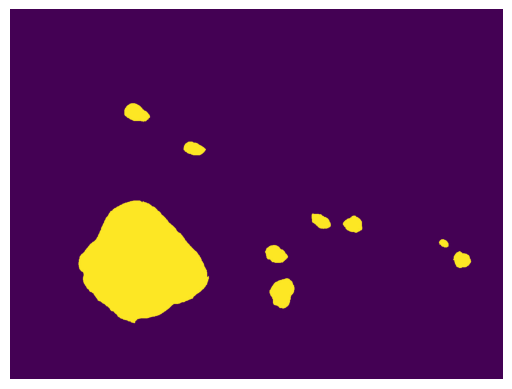

Displaying mask for image: single__C3_EndoCV2021_00367


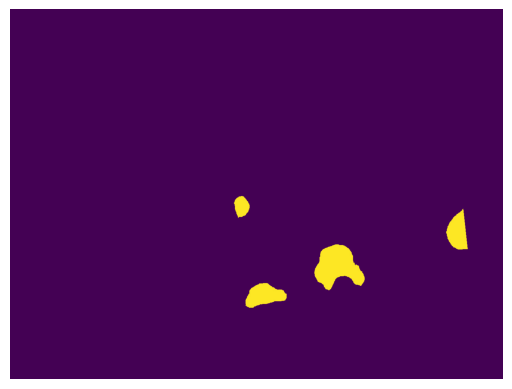

In [ ]:
# Display the mask image for each of these outliers
for index, row in small_outliers_sorted_by_area.iloc[30:40].iterrows():
    mask_path = row['mask_path']
    image_filename = row['image_filename']
    if mask_path and Path(mask_path).exists():
        print(f"Displaying mask for image: {image_filename}")
        display_image_from_path(mask_path)
    else:
        print(f"Mask file not found for image: {image_filename}")

All of the above 10 images have legitimately small regions.

# Removing pathological small bounding boxes

We have at least two possible approaches to remove pathological bounding boxes from our training data.

1. Keep the image, but remove the offending bounding box from the annotation
2. Completely remove the image and accompanying annotation from the training data

We decided to take the easier approach of simply removing pathological examples in their entirety instead of altering the annotations.

In [ ]:
import shutil

src = ROOT / "data/detection2/yolo_split2/train"
dst = ROOT / "data/detection2/yolo_split2/train_clean"

shutil.copytree(src, dst)

PosixPath('/content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean')

In [ ]:
# Manually constructed list of indices
bad_idx = [i for i in range(25) if i != 21]

# Delete from train_clean directory
for index, row in small_outliers_sorted_by_area.iloc[bad_idx].iterrows():
    image_filename = row['image_filename']
    image_path = ROOT / "data/detection2/yolo_split2/train_clean/images" / f"{image_filename}.jpg"
    annotation_path = ROOT / "data/detection2/yolo_split2/train_clean/labels" / f"{image_filename}.txt"
    if image_path.exists():
        image_path.unlink()
        print(f"Deleted image: {image_path}")
    else:
        print(f"Image file not found for image: {image_filename}")
    if annotation_path.exists():
        annotation_path.unlink()
        print(f"Deleted annotation: {annotation_path}")
    else:
        print(f"Annotation file not found for image: {image_filename}")


Deleted image: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/images/single__9_endocv2021_positive_538.jpg
Deleted annotation: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/labels/single__9_endocv2021_positive_538.txt
Deleted image: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/images/single__EndoCV2021_001118.jpg
Deleted annotation: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/labels/single__EndoCV2021_001118.txt
Deleted image: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/images/single__398OLCV1_100H0004.jpg
Deleted annotation: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/labels/single__398OLCV1_100H0004.txt
Deleted image: /content/drive/MyDrive/ErdosFall25/data/detection2/yolo_split2/train_clean/images/single__14_endocv2021_positive_902.jpg
Deleted annotation: /content/drive/MyDrive/ErdosFall25/data/detection2/